## Group 13 - IDC 409 Term Project

Members:
* Tushar Baruah (MS19015)
* Atharva Hingane (MS19043)
* Nitish (MS19101)

File for optimizations and tuning of our model

In [3]:
# Importing data and performing PCA

# data URL = https://drive.google.com/file/d/1wceoRWDkqdXrAAt6x6Kuf9Dv3alW3iad/view?usp=drive_link
# GITHUB link = https://github.com/TusharBaruah/Binary-Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Data = pd.read_csv('data_hep.csv')
Y_labels = Data['type'].to_numpy()

# re-labelling the data to signal (1) and background (0)
for i in range(0,len(Y_labels)):
    if(Y_labels[i]==0 or Y_labels[i]==1):
        Y_labels[i]=1.0 # signal
    else:
        Y_labels[i]=0.0 # background

Data = Data.drop('type',axis=1) # removing previous 'type' label
Data['type']=Y_labels # adding the signal and background label
X_set = Data.drop(columns=["Unnamed: 0","type"])
X_set = X_set.to_numpy()

pca= PCA(n_components=29)
result=pca.fit(X_set)
X_pca= result.transform(X_set)
print("Before PCA:",X_set.shape,"\nAfter PCA:",X_pca.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)
# print("X_train:",X_train.shape)
# print("X_test:",X_test.shape)
# print("Y_train:",Y_train.shape)
# print("Y_test:",Y_test.shape)

Before PCA: (70606, 59) 
After PCA: (70606, 29)


In [4]:
# Tuning different test sizes

import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math 

def sigmoid(x):
    x = np.float64(x)
    y = 1 / (1 + np.exp(-x))
    return y

def our_log(input):
    if(input < 0.00000000001):
        return - 2**30
    else:
        return np.log(input)
    
# Function to compute cost  - using vectorization
def cost_logreg_vec(X, y, w, b):
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = sigmoid(z)
    loss_vec = np.array([- (y[i] * our_log(y_dash[i])) - ((1 - y[i]) * our_log(1 - y_dash[i])) for i in range(m)])
    # loss_vec = np.array([- (y[i] * np.log(y_dash[i])) - ((1 - y[i]) * np.log(1 - y_dash[i])) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    # cost = cost_func_vec(y, y_dash)
    return cost

def grad_logreg_vec(X, y, w, b): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    y_dash = sigmoid(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    
    return grad_w, grad_b

# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, learning_rate, n_iter, show_cost = False): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    cost_history, params_history = [], []

    for i in range(n_iter):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - learning_rate * grad_w
        b += - learning_rate * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and (i == n_iter - 1):
            print("Iteration",i,",Cost:",float(cost_history[i]))
        
    return w, b, cost_history, params_history

PrecisionTestArray = []
PrecisionTrainArray = []
TestAccuracyArray = []
TrainAccuracyArray = []
RecallTestArray = []
RecallTrainArray = []
F1scoreTestArray = []
F1scoreTrainArray = []
SplitArray = np.arange(0.1,1.0,0.1)

for split in SplitArray:
    start = time.time()

    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = split, random_state=0)

    # Learning model parameters using gradient descent algorithm
    a=np.zeros(X_train.shape[1])

    w_out, b_out, cost_history, params_history = grad_desc(X_train,
                                                        Y_train,
                                                        a,
                                                        0,
                                                        learning_rate = 0.1,
                                                        n_iter = 250)

    # Prediction and evaluation on the training set and the test set
    y_train_prob = sigmoid(np.matmul(X_train, w_out) + (b_out * np.ones(X_train.shape[0])))
    y_test_prob = sigmoid(np.matmul(X_test, w_out) + (b_out * np.ones(X_test.shape[0])))
    y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)

    end = time.time()
    print("Time taken by the algorithm=",end-start,"seconds")

    # print("Training:\n",classification_report(Y_train, y_train_pred))
    # print("Testing:\n",classification_report(Y_test, y_test_pred))

    cmTest = confusion_matrix(Y_test, y_test_pred)
    cmTrain = confusion_matrix(Y_train, y_train_pred)
    # print('Confusion matrix\n', cm)
    # print('True Positives(TP) = ', cm[0,0])
    # print('True Negatives(TN) = ', cm[1,1])
    # print('False Positives(FP) = ', cm[0,1])
    # print('False Negatives(FN) = ', cm[1,0])

    # calculate these and append to list
    recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
    recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

    trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
    testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

    precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
    precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

    f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
    f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

    PrecisionTestArray.append(precisionTest)
    PrecisionTrainArray.append(precisionTrain)
    TestAccuracyArray.append(testAccuracy)
    TrainAccuracyArray.append(trainAccuracy)
    RecallTestArray.append(recallTest)
    RecallTrainArray.append(recallTrain)
    F1scoreTestArray.append(f1scoreTest)
    F1scoreTrainArray.append(f1scoreTrain)


Time taken by the algorithm= 47.92857003211975 seconds
Time taken by the algorithm= 42.1316819190979 seconds
Time taken by the algorithm= 37.94868779182434 seconds
Time taken by the algorithm= 32.710654973983765 seconds
Time taken by the algorithm= 25.59933066368103 seconds
Time taken by the algorithm= 21.20943284034729 seconds
Time taken by the algorithm= 15.185421228408813 seconds
Time taken by the algorithm= 10.60792350769043 seconds
Time taken by the algorithm= 4.581494569778442 seconds


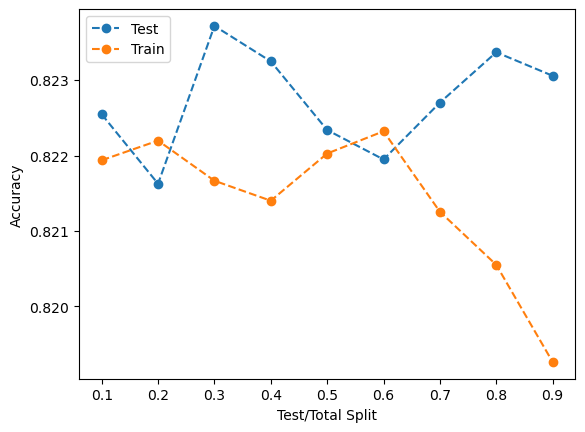

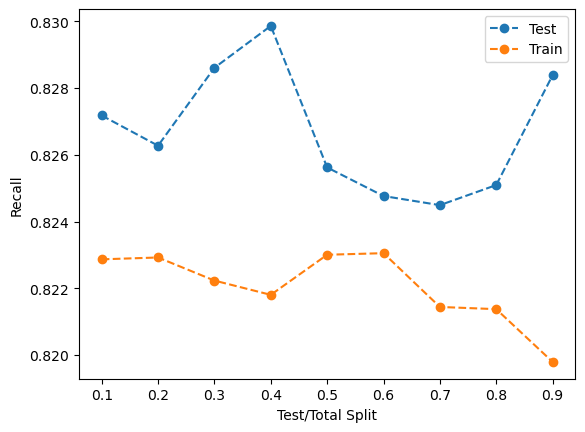

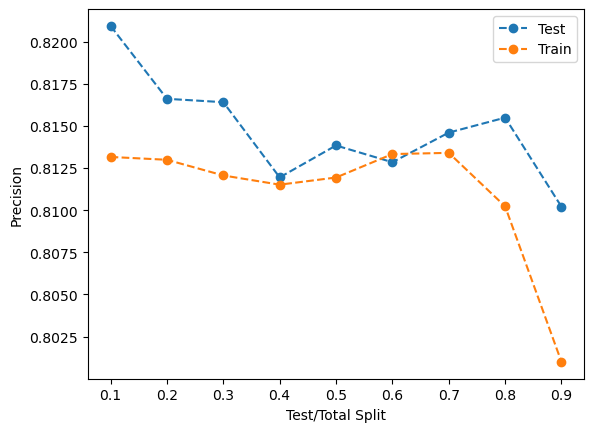

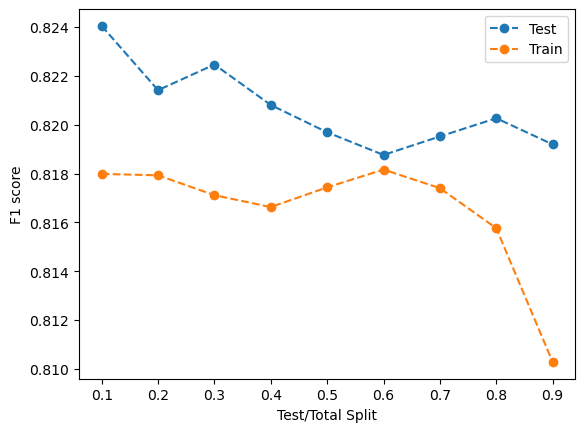

In [5]:
# plotting against test size
import matplotlib.pyplot as plt

# put a suitable location to save plots
location = 'E:/Studies/9th_semester_2023/IDC409_intro_DS/project/plots/'

plt.plot(SplitArray,TestAccuracyArray,marker='o',ls='--',label='Test')
plt.plot(SplitArray,TrainAccuracyArray,marker='o',ls='--',label='Train')
plt.xlabel('Test/Total Split')
plt.ylabel('Accuracy')
# plt.ylim(0.81,1)
plt.legend()
plt.savefig(location+'accuracy_vs_testSize.pdf',bbox_inches='tight')
plt.show()

plt.plot(SplitArray,RecallTestArray,marker='o',ls='--',label='Test')
plt.plot(SplitArray,RecallTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('Test/Total Split')
plt.ylabel('Recall')
plt.legend()
plt.savefig(location+'recall_vs_testSize.pdf',bbox_inches='tight')
plt.show()

plt.plot(SplitArray,PrecisionTestArray,marker='o',ls='--',label='Test')
plt.plot(SplitArray,PrecisionTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('Test/Total Split')
plt.ylabel('Precision')
plt.legend()
plt.savefig(location+'precision_vs_testSize.pdf',bbox_inches='tight')
plt.show()

plt.plot(SplitArray,F1scoreTestArray,marker='o',ls='--',label='Test')
plt.plot(SplitArray,F1scoreTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('Test/Total Split')
plt.ylabel('F1 score')
plt.legend()
plt.savefig(location+'f1score_vs_testSize.pdf',bbox_inches='tight')
plt.show()

In [6]:
# tuning different number of PCA components

from sklearn.metrics import confusion_matrix
import time

def sigmoid(x):
        x = np.float64(x)
        y = 1 / (1 + np.exp(-x))
        return y

def our_log(input):
    if(input < 0.00000000001):
        return - 2**30
    else:
        return np.log(input)
    
# Function to compute cost  - using vectorization
def cost_logreg_vec(X, y, w, b):
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = sigmoid(z)
    loss_vec = np.array([- (y[i] * our_log(y_dash[i])) - ((1 - y[i]) * our_log(1 - y_dash[i])) for i in range(m)])
    # loss_vec = np.array([- (y[i] * np.log(y_dash[i])) - ((1 - y[i]) * np.log(1 - y_dash[i])) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    # cost = cost_func_vec(y, y_dash)
    return cost

def grad_logreg_vec(X, y, w, b): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    y_dash = sigmoid(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    
    return grad_w, grad_b

# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, learning_rate, n_iter, show_cost = False): 
    m, n = X.shape
    if(len(y)!=m or len(w) !=n):
        print("Dataset array and Labels/weights array size does not match")
    cost_history, params_history = [], []

    for i in range(n_iter):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - learning_rate * grad_w
        b += - learning_rate * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and (i == n_iter - 1):
            print("Iteration",i,",Cost:",float(cost_history[i]))
        
    return w, b, cost_history, params_history

tt = []
PrecisionTestArray = []
PrecisionTrainArray = []
TestAccuracyArray = []
TrainAccuracyArray = []
RecallTestArray = []
RecallTrainArray = []
F1scoreTestArray = []
F1scoreTrainArray = []

for i in range(11,59,2):
    pca= PCA(n_components=i)
    result=pca.fit(X_set)
    X_pca= result.transform(X_set)
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_labels, test_size = 0.3, random_state=0)
    
    start = time.time()
    
     
    # Learning model parameters using gradient descent algorithm
    a=np.zeros(X_train.shape[1])

    w_out, b_out, cost_history, params_history = grad_desc(X_train,
                                                        Y_train,
                                                        a,
                                                        0,
                                                        learning_rate = 0.1,
                                                        n_iter = 250)

    # Prediction and evaluation on the training set and the test set
    y_train_prob = sigmoid(np.matmul(X_train, w_out) + (b_out * np.ones(X_train.shape[0])))
    y_test_prob = sigmoid(np.matmul(X_test, w_out) + (b_out * np.ones(X_test.shape[0])))
    y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)

    end = time.time()

    tt.append(end-start)
    cmTest = confusion_matrix(Y_test, y_test_pred)
    cmTrain = confusion_matrix(Y_train, y_train_pred)
    recallTest = cmTest[0,0]/(cmTest[0,0]+cmTest[1,0])
    recallTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[1,0])

    trainAccuracy = (cmTrain[0,0]+cmTrain[1,1])/len(X_train)
    testAccuracy = (cmTest[0,0]+cmTest[1,1])/len(X_test)

    precisionTest = cmTest[0,0]/(cmTest[0,0]+cmTest[0,1])
    precisionTrain = cmTrain[0,0]/(cmTrain[0,0]+cmTrain[0,1])

    f1scoreTest = 2 * (precisionTest * recallTest)/(precisionTest + recallTest)
    f1scoreTrain = 2 * (precisionTrain * recallTrain)/(precisionTrain + recallTrain)

    PrecisionTestArray.append(precisionTest)
    PrecisionTrainArray.append(precisionTrain)
    TestAccuracyArray.append(testAccuracy)
    TrainAccuracyArray.append(trainAccuracy)
    RecallTestArray.append(recallTest)
    RecallTrainArray.append(recallTrain)
    F1scoreTestArray.append(f1scoreTest)
    F1scoreTrainArray.append(f1scoreTrain)


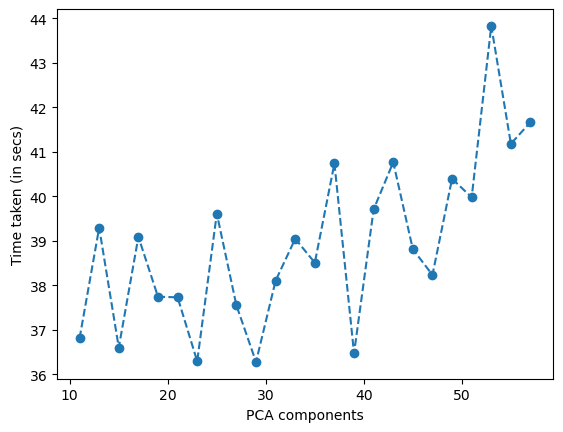

In [7]:
# plotting against PCA components

# put a suitable location to save plots
location = 'E:/Studies/9th_semester_2023/IDC409_intro_DS/project/plots/'

plt.plot(np.arange(11,59,2),tt,marker='o',ls='--')
plt.xlabel('PCA components')
plt.ylabel('Time taken (in secs)')
# plt.ylim(50,100)
# plt.legend()
plt.savefig(location+'time_vs_PCAcomponents.pdf',bbox_inches='tight')
plt.show()

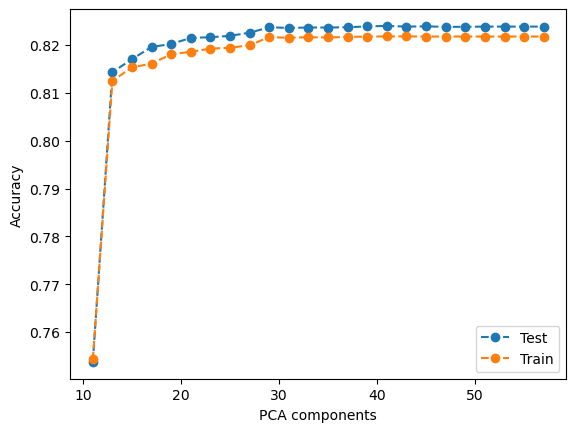

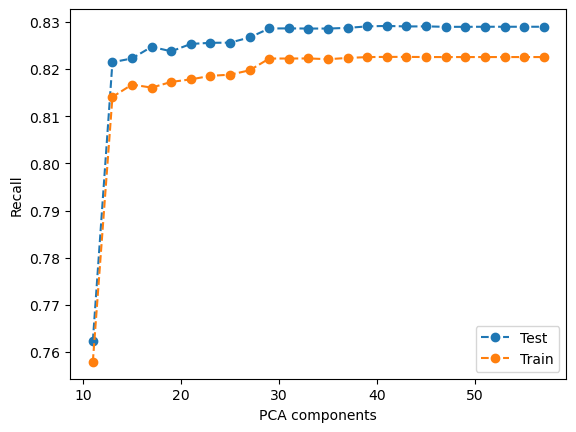

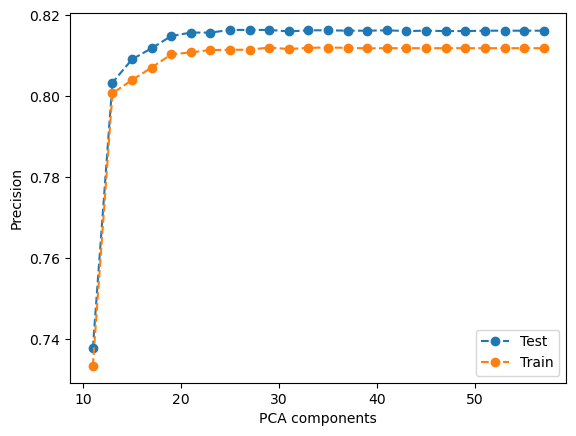

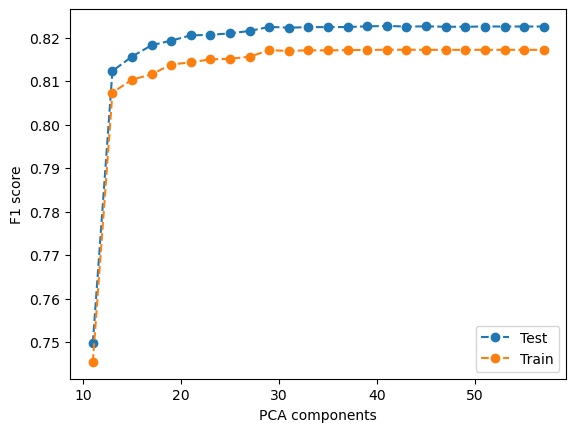

In [8]:
# put a suitable location to save plots
location = 'E:/Studies/9th_semester_2023/IDC409_intro_DS/project/plots/'

plt.plot(np.arange(11,59,2),TestAccuracyArray,marker='o',ls='--',label='Test')
plt.plot(np.arange(11,59,2),TrainAccuracyArray,marker='o',ls='--',label='Train')
plt.xlabel('PCA components')
plt.ylabel('Accuracy')
# plt.ylim(0.81,1)
plt.legend()
plt.savefig(location+'accuracy_vs_PCAcomponents.pdf',bbox_inches='tight')
plt.show()

plt.plot(np.arange(11,59,2),RecallTestArray,marker='o',ls='--',label='Test')
plt.plot(np.arange(11,59,2),RecallTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('PCA components')
plt.ylabel('Recall')
plt.legend()
plt.savefig(location+'recall_vs_PCAcomponents.pdf',bbox_inches='tight')
plt.show()

plt.plot(np.arange(11,59,2),PrecisionTestArray,marker='o',ls='--',label='Test')
plt.plot(np.arange(11,59,2),PrecisionTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('PCA components')
plt.ylabel('Precision')
plt.legend()
plt.savefig(location+'precision_vs_PCAcomponents.pdf',bbox_inches='tight')
plt.show()

plt.plot(np.arange(11,59,2),F1scoreTestArray,marker='o',ls='--',label='Test')
plt.plot(np.arange(11,59,2),F1scoreTrainArray,marker='o',ls='--',label='Train')
plt.xlabel('PCA components')
plt.ylabel('F1 score')
plt.legend()
plt.savefig(location+'f1score_vs_PCAcomponents.pdf',bbox_inches='tight')
plt.show()